In [2]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,\
      mean_squared_log_error, mean_absolute_error, make_scorer, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from scipy.stats import skew
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import shap

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.set_index('OSEBuildingID', inplace = True)

In [5]:
data =data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [6]:
cols = ['Age','PropertyGFATotal',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
       'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'TotalGHGEmissions']

Age
0.29753360879193896


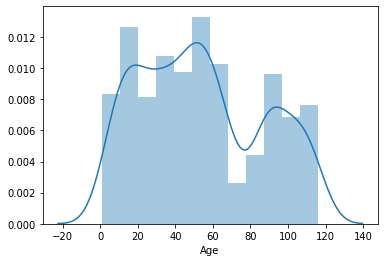

PropertyGFATotal
19.037917545145827


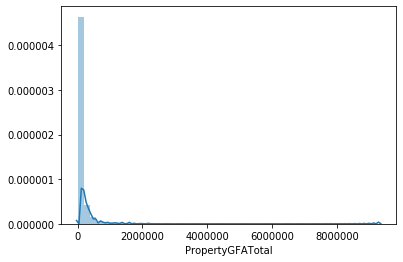

SiteEUI(kBtu/sf)
3.767000453173848


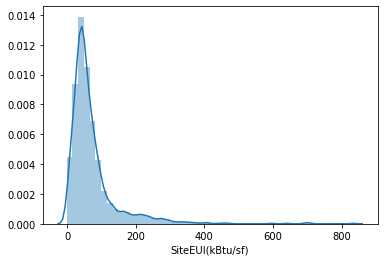

SiteEUIWN(kBtu/sf)
3.6664593768907086


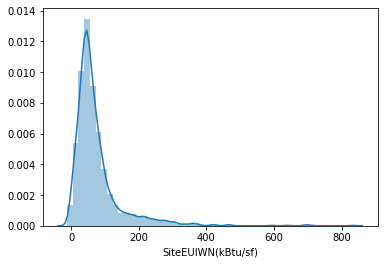

SourceEUI(kBtu/sf)
5.02139873400849


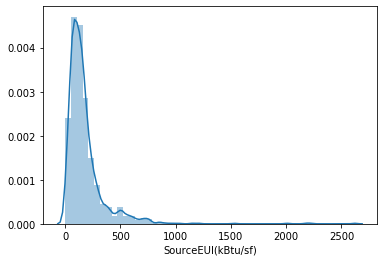

SourceEUIWN(kBtu/sf)
4.998804175082916


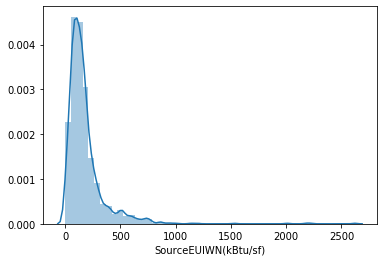

SiteEnergyUse(kBtu)
17.973308078803022


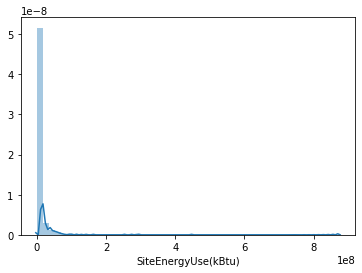

SiteEnergyUseWN(kBtu)
11.273463145790341


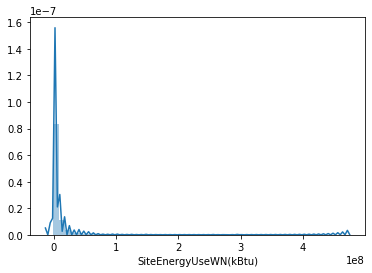

LargestPropertyUseTypeGFA
23.175161728669494


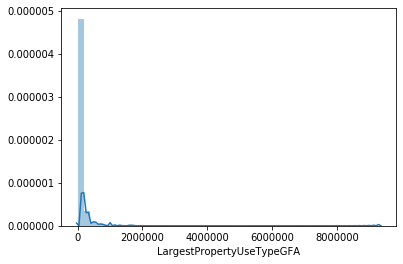

ENERGYSTARScore
0.07727154779048637


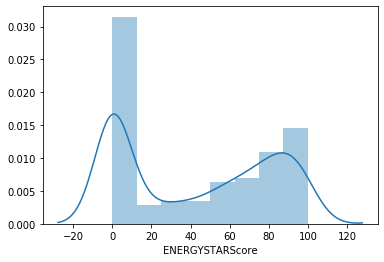

TotalGHGEmissions
14.130616835139792


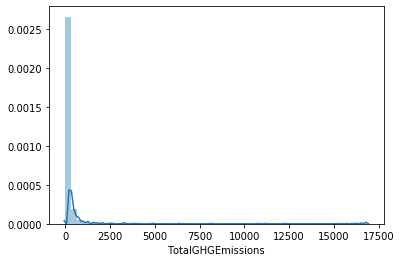

In [7]:
for col in cols:
      print(col)
      print(skew(data[col]))

      plt.figure()
      sns.distplot(data[col])
      plt.show()

In [8]:
cols = ['Age','PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','PropertyGFATotal',
        'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'TotalGHGEmissions']

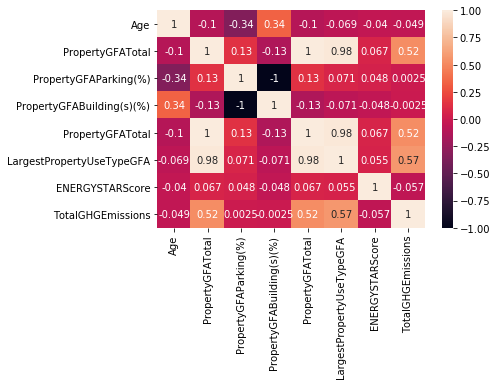

In [9]:
sns.heatmap(data[cols].corr(), annot = True)

In [10]:
X = data[['Age','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','LargestPropertyUseTypeGFA','ENERGYSTARScore','EnergyStarNaN',
        'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility','CouncilDistrictCode_1',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'CouncilDistrictCode_7']]


y = data['TotalGHGEmissions']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
colsk = ['Age','PropertyGFATotal', 'LargestPropertyUseTypeGFA','ENERGYSTARScore']
X_train_tt = X_train.copy()
X_test_tt = X_test.copy()
X_train_tt[colsk] = np.log1p(X_train_tt[colsk])
X_test_tt[colsk] = np.log1p(X_test_tt[colsk])

In [13]:
std_scale = StandardScaler()
std_scale.fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
X_train_tt = std_scale.transform(X_train_tt)
X_test_tt = std_scale.transform(X_test_tt)
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)
X_train_tt = pd.DataFrame(X_train_tt, columns = X.columns)
X_test_tt = pd.DataFrame(X_test_tt, columns = X.columns)

In [14]:
dr = DummyRegressor(strategy="mean")
dr.fit(X_train, y_train)
baseline_error = mean_squared_error(y_test, dr.predict(y_test), squared=False)
baseline_error

770.5687305972889

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_error = mean_squared_error(y_test, lr.predict(X_test), squared=False)
lr_error

614.7720113903748

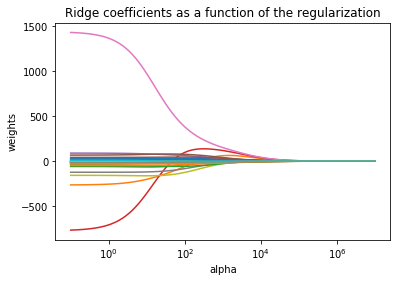

In [16]:
n_alphas = 100
alphas = np.logspace(-1, 7, n_alphas)

ridge = Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, mean_squared_error(y_test, ridge.predict(X_test), squared=False)])

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

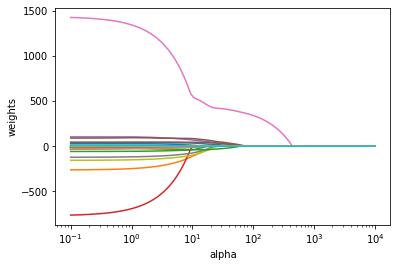

In [17]:
n_alphas = 100
alphas = np.logspace(-1, 4, n_alphas)
lasso = Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(X_test) - y_test) ** 2)])


ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

In [18]:
def resultize(grid):

    res = pd.DataFrame(grid.cv_results_)
    res = res[['params', 'mean_test_RMSE', 'rank_test_RMSE', 'mean_test_MSE', 'rank_test_MSE', 'mean_test_MAE', 'rank_test_MAE', 'mean_test_R2', 'rank_test_R2']]
    res['mean_test_MSE'] = (-res[f'mean_test_MSE'])
    res['mean_test_RMSE'] = (-res[f'mean_test_RMSE'])
    res['mean_test_MAE'] = (-res[f'mean_test_MAE'])
    res.sort_values(by='rank_test_RMSE', inplace=True)
    return res

In [19]:
s = {'MSE': 'neg_mean_squared_error', 
      'RMSE': 'neg_root_mean_squared_error',
      'MAE': 'neg_mean_absolute_error',
      'R2': 'r2'}
score = 'RMSE'

In [20]:
params = {'alpha': np.logspace(0, 7, 20)}
grid_ridge = GridSearchCV(Ridge(), params, cv = 10, 
                  scoring = s, refit = score, n_jobs=-1)
grid_ridge.fit(X_train, y_train)
grid_ridge_best_params = grid_ridge.best_params_
resultize(grid_ridge).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
8,{'alpha': 885.8667904100823},476.639195,1,391733.232026,1,158.033462,1,0.174566,2
7,{'alpha': 379.26901907322497},499.014277,2,399812.073361,2,166.462100,2,0.098645,4
9,{'alpha': 2069.138081114788},516.894437,3,430045.350869,3,167.498079,3,0.175937,1
10,{'alpha': 4832.930238571752},554.135987,4,478036.314766,4,181.645970,4,0.121211,3
6,{'alpha': 162.3776739188721},558.543953,5,487951.291381,5,183.185330,5,-0.068267,7


In [21]:
grid_ridge_best_params = {'alpha': 885.8667904100823}	

In [22]:
ridge = Ridge(**grid_ridge_best_params)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
ridge_error = mean_squared_error(y_test, y_pred, squared=False)
ridge_error

672.8791568764291

In [23]:
params = {"alpha": np.logspace(-1, 3, 30)}
grid_lasso = GridSearchCV(Lasso(), params, cv = 10, 
                  scoring = s, refit = score, n_jobs=-1)
grid_lasso.fit(X_train, y_train)
grid_lasso_best_params = grid_lasso.best_params_
resultize(grid_lasso).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
22,{'alpha': 108.2636733874054},482.539769,1,390921.906220,2,166.906055,3,0.155596,1
21,{'alpha': 78.80462815669912},488.342255,2,390012.762722,1,165.871353,2,0.137284,3
20,{'alpha': 57.361525104486816},512.534425,3,409277.421348,3,165.864468,1,0.111911,4
23,{'alpha': 148.73521072935117},519.468991,4,423490.886398,4,174.215708,6,0.142675,2
19,{'alpha': 41.753189365604},549.353859,5,468634.669624,5,168.319308,4,0.054916,6


In [24]:
grid_lasso_best_params = {'alpha': 108.2636733874054}

In [25]:
lasso = Lasso(**grid_lasso_best_params)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
lasso_error = mean_squared_error(y_test, y_pred, squared=False)
lasso_error

681.1888577167889

In [26]:
"""tt_ridge = TransformedTargetRegressor(regressor = Ridge(),
                               func = np.log1p,
                               inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(0, 7, 100)}
grid_tt_ridge = GridSearchCV(tt_ridge, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_ridge.fit(X_train_tt, y_train)
grid_tt_ridge_best_params = grid_tt_ridge.best_params_
resultize(grid_tt_ridge).head()"""
#10s

"tt_ridge = TransformedTargetRegressor(regressor = Ridge(),\n                               func = np.log1p,\n                               inverse_func = np.expm1)\nparams = {'regressor__alpha': np.logspace(0, 7, 100)}\ngrid_tt_ridge = GridSearchCV(tt_ridge, scoring=s, refit = score, param_grid=params, cv = 10)\ngrid_tt_ridge.fit(X_train_tt, y_train)\ngrid_tt_ridge_best_params = grid_tt_ridge.best_params_\nresultize(grid_tt_ridge).head()"

In [27]:
grid_tt_ridge_best_params = {'alpha': 413.20124001153346}

In [28]:
tt_ridge = TransformedTargetRegressor(regressor = Ridge(**grid_tt_ridge_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ridge.fit(X_train_tt, y_train)
y_pred = tt_ridge.predict(X_test_tt)
tt_ridge_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ridge_error

783.9703683523167

In [29]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(-1, 3, 30)}
grid_tt_lasso = GridSearchCV(tt_lasso, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_lasso.fit(X_train_tt, y_train)
grid_tt_lasso_best_params = grid_tt_lasso.best_params_
resultize(grid_tt_lasso).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
1,{'regressor__alpha': 0.1373823795883263},615.054720,1,575334.088455,2,154.215587,2,0.027574,1
2,{'regressor__alpha': 0.18873918221350972},616.212353,2,575120.913624,1,155.208703,3,0.013224,3
0,{'regressor__alpha': 0.1},616.501047,3,578332.669582,4,153.792395,1,0.026572,2
3,{'regressor__alpha': 0.2592943797404667},619.937909,4,577916.425811,3,157.671034,4,-0.013550,4
4,{'regressor__alpha': 0.3562247890262442},623.603543,5,580902.075530,5,161.424240,5,-0.040006,5


In [30]:
grid_tt_lasso_best_params = {'alpha': 0.1373823795883263}

In [31]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(**grid_tt_lasso_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_lasso.fit(X_train_tt, y_train)
y_pred = tt_lasso.predict(X_test_tt)
tt_lasso_error = mean_squared_error(y_test, y_pred, squared=False)
tt_lasso_error

957.6697070068947

In [32]:
params = {'kernel': ['sigmoid','rbf','poly'],
         'C': [0.1,1,100,1000],
         'degree': [1,2,3,4,5,6]}
grid_svr = GridSearchCV(SVR(), params, cv=10, scoring = s,
                        refit = score,  n_jobs=-1)
grid_svr.fit(X_train, y_train)
best_params_svr = grid_svr.best_params_
resultize(grid_svr).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
56,"{'C': 1000, 'degree': 1, 'kernel': 'poly'}",475.803318,1,395389.542506,1,125.826171,1,0.323142,1
38,"{'C': 100, 'degree': 1, 'kernel': 'poly'}",490.866822,2,411039.931766,2,126.764483,2,0.310659,2
64,"{'C': 1000, 'degree': 4, 'kernel': 'rbf'}",532.779024,3,470455.441298,3,130.545493,3,0.296809,3
67,"{'C': 1000, 'degree': 5, 'kernel': 'rbf'}",532.779024,3,470455.441298,3,130.545493,3,0.296809,3
61,"{'C': 1000, 'degree': 3, 'kernel': 'rbf'}",532.779024,3,470455.441298,3,130.545493,3,0.296809,3


In [33]:
best_params_svr = {'C': 1000, 'degree': 1, 'kernel': 'poly'}

In [34]:
svr = SVR(**best_params_svr)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
svr_error = mean_squared_error(y_test, y_pred, squared=False)
svr_error

684.9899041811699

In [35]:
'''tt_svr = TransformedTargetRegressor(regressor = SVR(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__C': [0.1,1,100,1000],
            'regressor__degree': [1,2,3,4,5,6]}
grid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_svr.fit(X_train_tt, y_train)
best_params_svr_tt = grid_tt_svr.best_params_
resultize(grid_tt_svr).head()'''

"tt_svr = TransformedTargetRegressor(regressor = SVR(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__C': [0.1,1,100,1000],\n            'regressor__degree': [1,2,3,4,5,6]}\ngrid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_svr.fit(X_train_tt, y_train)\nbest_params_svr_tt = grid_tt_svr.best_params_\nresultize(grid_tt_svr).head()"

In [36]:
best_params_svr_tt = {'C': 1, 'degree': 1}

In [37]:
tt_svr = TransformedTargetRegressor(regressor = SVR(**best_params_svr_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_svr.fit(X_train_tt, y_train)
y_pred = tt_svr.predict(X_test_tt)
tt_svr_error = mean_squared_error(y_test, y_pred, squared=False)
tt_svr_error

734.2138392637734

In [38]:
"""params = {'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [1,3,5,7,9],
            'min_samples_split': [3,5,7,9],
}
grid_rf = GridSearchCV(RandomForestRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_params_rf = grid_rf.best_params_
resultize(grid_rf).head()"""
#30s

"params = {'n_estimators': [100, 200, 300, 400, 500],\n            'max_depth': [1,3,5,7,9],\n            'min_samples_split': [3,5,7,9],\n}\ngrid_rf = GridSearchCV(RandomForestRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_rf.fit(X_train, y_train)\nbest_params_rf = grid_rf.best_params_\nresultize(grid_rf).head()"

In [39]:
best_params_rf = {'max_depth': 5, 'min_samples_split': 7, 'n_estimators': 100}

In [40]:
rf = RandomForestRegressor(**best_params_rf)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_error = mean_squared_error(y_test, y_pred, squared=False)
rf_error

504.3001899499749

In [41]:
"""tt_rf = TransformedTargetRegressor(regressor = RandomForestRegressor(**best_params_rf),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__max_depth': [1,3,5,7,9],
            'regressor__min_samples_split': [3,5,7,9]}
grid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_rf.fit(X_train_tt, y_train)
best_params_rf_tt = grid_tt_rf.best_params_
resultize(grid_tt_rf).head()"""
#30s

"tt_rf = TransformedTargetRegressor(regressor = RandomForestRegressor(**best_params_rf),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__max_depth': [1,3,5,7,9],\n            'regressor__min_samples_split': [3,5,7,9]}\ngrid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_rf.fit(X_train_tt, y_train)\nbest_params_rf_tt = grid_tt_rf.best_params_\nresultize(grid_tt_rf).head()"

In [42]:
best_params_rf_tt = {'max_depth': 7,
 'min_samples_split': 5,
 'n_estimators': 200}

In [43]:
rf_tt = TransformedTargetRegressor(
      regressor = RandomForestRegressor(**best_params_rf_tt),
      func = np.log1p,
      inverse_func = np.expm1)
rf_tt.fit(X_train_tt, y_train)
y_pred = rf_tt.predict(X_test_tt)
tt_rf_error = mean_squared_error(y_test, y_pred, squared=False)
tt_rf_error

561.7337879258677

In [44]:
"""params = {'loss': ['ls', 'lad', 'huber', 'quantile'],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [4, 6],
            'min_samples_leaf': [3, 5, 9, 17],
}
grid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_params_gb = grid_gb.best_params_
resultize(grid_gb).head()"""
#30s

"params = {'loss': ['ls', 'lad', 'huber', 'quantile'],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'max_depth': [4, 6],\n            'min_samples_leaf': [3, 5, 9, 17],\n}\ngrid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_gb.fit(X_train, y_train)\nbest_params_gb = grid_gb.best_params_\nresultize(grid_gb).head()"

In [45]:
best_params_gb = {'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 3}

In [46]:
gb = GradientBoostingRegressor(**best_params_gb)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb_error = mean_squared_error(y_test, y_pred, squared=False)
gb_error

501.00662747931955

In [47]:
'''tt_gb = TransformedTargetRegressor(regressor = GradientBoostingRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__max_depth': [4, 6],
            'regressor__min_samples_leaf': [3, 5, 9, 17]}
grid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_gb.fit(X_train_tt, y_train)
best_params_gb_tt = grid_tt_gb.best_params_
resultize(grid_tt_gb).head()'''

"tt_gb = TransformedTargetRegressor(regressor = GradientBoostingRegressor(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],\n            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'regressor__max_depth': [4, 6],\n            'regressor__min_samples_leaf': [3, 5, 9, 17]}\ngrid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_gb.fit(X_train_tt, y_train)\nbest_params_gb_tt = grid_tt_gb.best_params_\nresultize(grid_tt_gb).head()"

In [48]:
best_params_gb_tt = {'learning_rate': 0.1,
      'loss': 'huber',
      'max_depth': 6,
      'min_samples_leaf': 5}

In [49]:
gb_tt = TransformedTargetRegressor(GradientBoostingRegressor(**best_params_gb_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
gb_tt.fit(X_train_tt, y_train)
y_pred = gb_tt.predict(X_test_tt)
tt_gb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_gb_error

370.91272591900827

In [50]:
"""params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'loss': ['linear', 'square', 'exponential'],
}
grid_ad = GridSearchCV(AdaBoostRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_ad.fit(X_train, y_train)
best_params_ad = grid_ad.best_params_
resultize(grid_ad).head()"""
#20s

"params = {'n_estimators': [100, 200, 300, 400, 500],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'loss': ['linear', 'square', 'exponential'],\n}\ngrid_ad = GridSearchCV(AdaBoostRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_ad.fit(X_train, y_train)\nbest_params_ad = grid_ad.best_params_\nresultize(grid_ad).head()"

In [51]:
best_params_ad = {'learning_rate': 0.02, 'loss': 'linear', 'n_estimators': 100}

In [52]:
ad = AdaBoostRegressor(**best_params_ad)
ad.fit(X_train, y_train)
y_pred = ad.predict(X_test)
ad_error = mean_squared_error(y_test, y_pred, squared=False)
ad_error

419.97673191142303

In [53]:
'''tt_ad = TransformedTargetRegressor(regressor = AdaBoostRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__loss': ['linear', 'square', 'exponential'],
}
grid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_ad.fit(X_train_tt, y_train)
best_params_ad_tt = grid_tt_ad.best_params_
resultize(grid_tt_ad).head()'''

"tt_ad = TransformedTargetRegressor(regressor = AdaBoostRegressor(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'regressor__loss': ['linear', 'square', 'exponential'],\n}\ngrid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_ad.fit(X_train_tt, y_train)\nbest_params_ad_tt = grid_tt_ad.best_params_\nresultize(grid_tt_ad).head()"

In [54]:
best_params_ad_tt = {'learning_rate': 0.05,
      'loss': 'exponential',
      'n_estimators': 200
      }

In [55]:
tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(**best_params_ad_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ad.fit(X_train_tt, y_train)
y_pred = tt_ad.predict(X_test_tt)
tt_ad_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ad_error

614.3046192617641

In [56]:
"""params = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'adam'],
}
grid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_mlp.fit(X_train, y_train)
best_params_mlp = grid_mlp.best_params_
resultize(grid_mlp).head()"""
#1m20s

"params = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],\n            'activation': ['identity', 'logistic', 'tanh', 'relu'],\n            'solver': ['lbfgs', 'adam'],\n}\ngrid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_mlp.fit(X_train, y_train)\nbest_params_mlp = grid_mlp.best_params_\nresultize(grid_mlp).head()"

In [57]:
best_params_mlp = {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}

In [58]:
mlp = MLPRegressor(**best_params_mlp)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mlp_error = mean_squared_error(y_test, y_pred, squared=False)
mlp_error

677.78417230617

In [59]:
'''tt_mlp = TransformedTargetRegressor(regressor = MLPRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'regressor__solver': ['lbfgs', 'adam'],
}
grid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_mlp.fit(X_train_tt, y_train)
best_params_tt_mlp = grid_tt_mlp.best_params_
resultize(grid_tt_mlp).head()'''

"tt_mlp = TransformedTargetRegressor(regressor = MLPRegressor(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],\n            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],\n            'regressor__solver': ['lbfgs', 'adam'],\n}\ngrid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_mlp.fit(X_train_tt, y_train)\nbest_params_tt_mlp = grid_tt_mlp.best_params_\nresultize(grid_tt_mlp).head()"

In [60]:
best_params_tt_mlp = {'activation': 'logistic',
      'hidden_layer_sizes': (200,),
      'solver': 'adam'
      }

In [61]:
tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(**best_params_tt_mlp),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_mlp.fit(X_train_tt, y_train)
y_pred = tt_mlp.predict(X_test_tt)
tt_mlp_error = mean_squared_error(y_test, y_pred, squared=False)
tt_mlp_error

748.4338757840222

In [62]:
"""xgb = XGBRegressor()
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [2, 3, 4, 5, 6]}
grid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_params_xgb = grid_xgb.best_params_
resultize(grid_xgb).head()"""
#10mn

"xgb = XGBRegressor()\nparams = {'n_estimators': [100, 200, 300, 400, 500],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'max_depth': [2, 3, 4, 5, 6]}\ngrid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_xgb.fit(X_train, y_train)\nbest_params_xgb = grid_xgb.best_params_\nresultize(grid_xgb).head()"

In [63]:
best_params_xgb = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

In [64]:
xgb = XGBRegressor(**best_params_xgb)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_error = mean_squared_error(y_test, y_pred, squared=False)
xgb_error

732.0056455146107

In [65]:
"""tt_xgb = TransformedTargetRegressor(regressor = XGBRegressor(**best_params_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.05, 0.02, 0.01],
            'regressor__max_depth': [2, 3, 4, 5, 6]}
grid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_xgb.fit(X_train_tt, y_train)
best_params_tt_xgb = grid_tt_xgb.best_params_
resultize(grid_tt_xgb).head()"""
#7mn

"tt_xgb = TransformedTargetRegressor(regressor = XGBRegressor(**best_params_xgb),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__learning_rate': [0.05, 0.02, 0.01],\n            'regressor__max_depth': [2, 3, 4, 5, 6]}\ngrid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_xgb.fit(X_train_tt, y_train)\nbest_params_tt_xgb = grid_tt_xgb.best_params_\nresultize(grid_tt_xgb).head()"

In [66]:
best_params_tt_xgb = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}

In [67]:
tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(**best_params_tt_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_xgb.fit(X_train_tt, y_train)
y_pred = tt_xgb.predict(X_test_tt)
tt_xgb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_xgb_error

416.68757116603183

In [68]:
errors = {'Baseline': baseline_error,
            'Linear Regression': lr_error,
            'Ridge': ridge_error,
            'Ridge_tt': tt_ridge_error,
            'Lasso': lasso_error,
            'Lasso_tt': tt_lasso_error,
            'SVR': svr_error,
            'SVR_tt': tt_svr_error,
            'Random Forest': rf_error,
            'Random Forest_tt': tt_rf_error,
            'Gradient Boosting': gb_error,
            'Gradient Boosting_tt': tt_gb_error,
            'AdaBoost': ad_error,
            'AdaBoost_tt': tt_ad_error,
            'MLP': mlp_error,
            'MLP_tt': tt_mlp_error,
            'XGBoost': xgb_error,
            'XGBoost_tt': tt_xgb_error
}

In [69]:
#Classement des erreurs
errors = pd.DataFrame(errors.items(), columns=['Model', 'RMSE'])
errors = errors.sort_values(by='RMSE', ascending=True)
errors

,Model,RMSE
11,Gradient Boosting_tt,370.912726
17,XGBoost_tt,416.687571
12,AdaBoost,419.976732
10,Gradient Boosting,501.006627
8,Random Forest,504.300190
9,Random Forest_tt,561.733788
13,AdaBoost_tt,614.304619
1,Linear Regression,614.772011
2,Ridge,672.879157
14,MLP,677.784172


In [70]:
gb_tt.regressor_.feature_importances_

array([8.15423600e-02, 6.87230380e-03, 1.07008368e-01, 1.31393160e-01,
       8.80513951e-03, 7.31344307e-03, 3.37719214e-01, 9.97879093e-02,
       3.19040712e-03, 5.29156714e-03, 1.08868629e-02, 9.49748194e-03,
       9.54905462e-03, 1.15613362e-03, 4.03529698e-03, 2.65902858e-02,
       3.34849093e-03, 1.02914777e-02, 4.55017832e-02, 3.39948504e-02,
       4.58964285e-04, 2.95573321e-02, 3.25899023e-04, 3.40706319e-03,
       6.84419984e-03, 6.38136219e-03, 1.78443842e-03, 2.46596199e-03,
       5.90744041e-04, 4.40844464e-03])

In [78]:
feat_imp_gb_tt = pd.DataFrame({'importance': gb_tt.regressor_.feature_importances_})
feat_imp_gb_tt['feature'] = X_train.columns
feat_imp_gb_tt = feat_imp_gb_tt.sort_values(by='importance', ascending=False)
feat_imp_gb_tt

,importance,feature
6,0.337719,LargestPropertyUseTypeGFA
3,0.131393,PropertyGFATotal
2,0.107008,NumberofFloors
7,0.099788,ENERGYSTARScore
0,0.081542,Age
18,0.045502,PrimaryPropertyType_Small- and Mid-Sized Office
19,0.033995,PrimaryPropertyType_Supermarket / Grocery Store
21,0.029557,PrimaryPropertyType_Warehouse
15,0.026590,PrimaryPropertyType_Other
10,0.010887,PrimaryPropertyType_Hotel


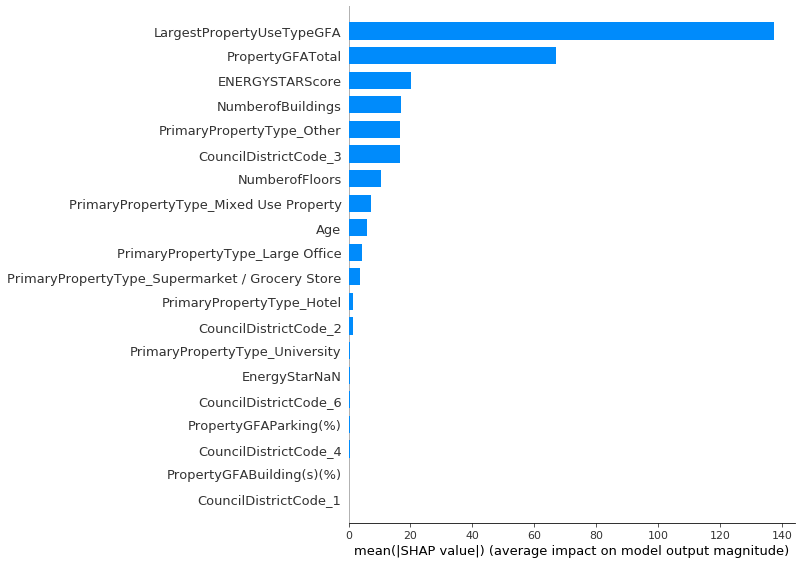

In [71]:
explainer = shap.TreeExplainer(rf, X_train)
shap_values = explainer.shap_values(X_test, check_additivity=False)
shap.summary_plot(shap_values, X_test, plot_type="bar")

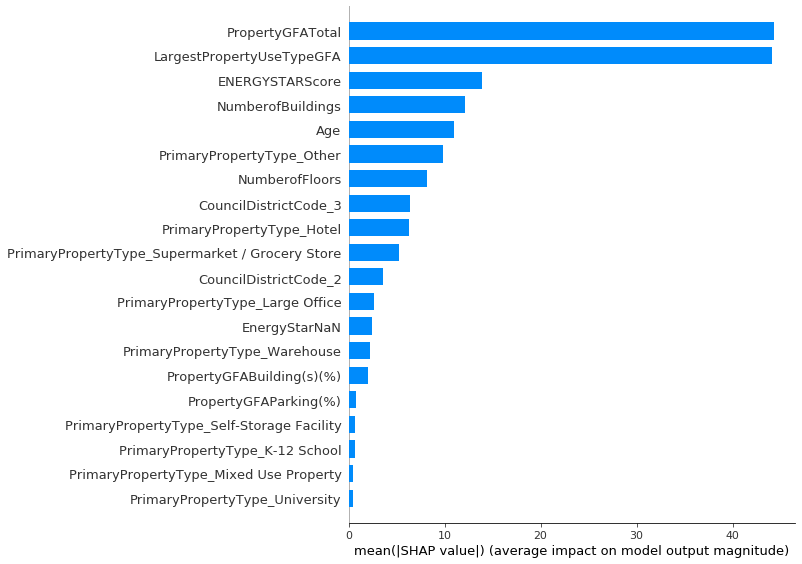

In [72]:
explainer = shap.TreeExplainer(gb, X_train)
shap_values = explainer.shap_values(X_test_tt, check_additivity=False)
shap.summary_plot(shap_values, X_test_tt, plot_type="bar")

In [73]:
#print feature importance with names
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': gb.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
feature_importance

,feature,importance
3,PropertyGFATotal,0.417048
6,LargestPropertyUseTypeGFA,0.170763
7,ENERGYSTARScore,0.072146
0,Age,0.055866
2,NumberofFloors,0.048366
19,PrimaryPropertyType_Supermarket / Grocery Store,0.047576
15,PrimaryPropertyType_Other,0.031764
10,PrimaryPropertyType_Hotel,0.028269
21,PrimaryPropertyType_Warehouse,0.021345
12,PrimaryPropertyType_Large Office,0.019175


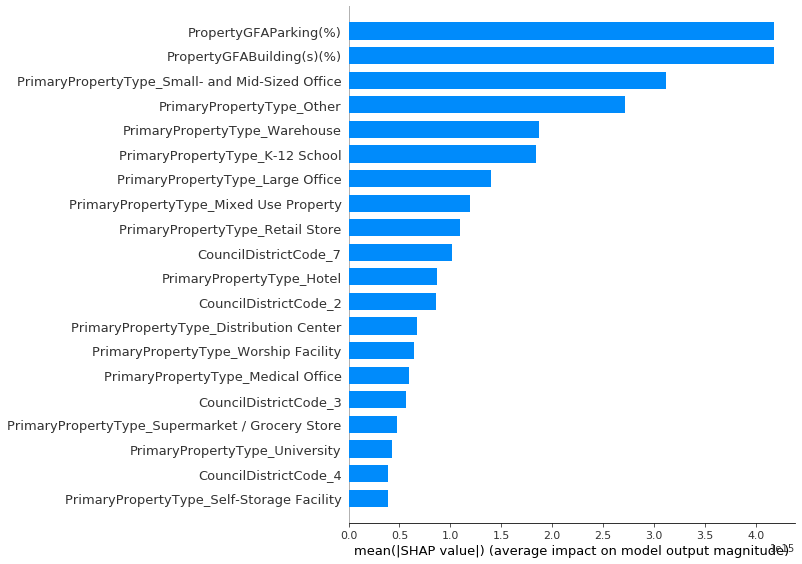

In [74]:
explainer_lr = shap.LinearExplainer(lr, X_train)
shap_values_lr = explainer_lr.shap_values(X_test)
shap.summary_plot(shap_values_lr, X_test, plot_type="bar")

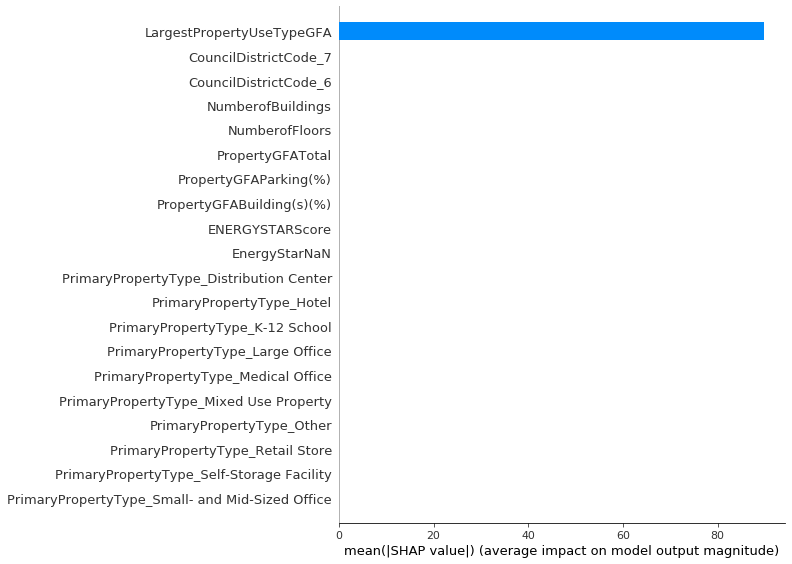

In [75]:
explainer_lasso = shap.LinearExplainer(lasso, X_train)
shap_values_lasso = explainer_lasso.shap_values(X_test)
shap.summary_plot(shap_values_lasso, X_test, plot_type="bar")